# Clusters

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Libraries imported successfully!')

✓ Libraries imported successfully!


## 2. Load and Prepare Data

In [2]:
# Load cleaned data
df = pd.read_csv('../data/data_cleaned.csv')

# Replace <Null> with NaN
df = df.replace('<Null>', np.nan)

# Convert date column
df['INSPECTION_DATE'] = pd.to_datetime(df['INSPECTION_DATE'], format='%m/%d/%y', errors='coerce')

# Filter for confirmed cases with valid coordinates
df_confirmed = df[
    (df['OAK_WILT_CONFIRMED'] == 'Yes') & 
    (df['LATITUDE'].notna()) & 
    (df['LONGITUDE'].notna()) &
    (df['INSPECTION_YEAR'].notna())
].copy()

print(f'✓ Loaded {len(df):,} total records')
print(f'✓ Using {len(df_confirmed):,} confirmed cases with valid coordinates')
print(f'✓ Date range: {df_confirmed["INSPECTION_YEAR"].min():.0f} to {df_confirmed["INSPECTION_YEAR"].max():.0f}')

df_confirmed.head()

✓ Loaded 1,682 total records
✓ Using 1,672 confirmed cases with valid coordinates
✓ Date range: 1986 to 2024


,Inspection_ID (unique),MORTALITY_CENTER_ID,INSPECTION_DATE,INSPECTION_DECADE,INSPECTION_YEAR,SPECIES,LATITUDE,LONGITUDE,LANDOWNER_TYPE,OAK_WILT_CONFIRMED,SYMPTOM_VEINAL_NECROSIS,SYMPTOM_MORTALITY_PATTERN
0,NaN,5758.0,1986-08-24,1980s,1986,Live Oak,30.318636,-97.766907,Unknown,Yes,NaN,NaN
1,NaN,5723.0,1987-03-11,1980s,1987,Live Oak,30.263226,-97.804992,Unknown,Yes,Yes,NaN
2,NaN,5782.0,1988-03-17,1980s,1988,Live Oak,30.247574,-97.759786,Unknown,Yes,NaN,NaN
3,NaN,5807.0,1988-05-06,1980s,1988,Live Oak,30.229521,-97.859917,Unknown,Yes,Yes,NaN
4,NaN,5689.0,1988-12-06,1980s,1988,Live Oak,30.388368,-97.687027,Unknown,Yes,Yes,NaN


## 3. Feature Engineering for Clustering

We'll create features that combine spatial and temporal dimensions.

In [3]:
# Create clustering features
clustering_data = df_confirmed[['LATITUDE', 'LONGITUDE', 'INSPECTION_YEAR']].copy()

# Normalize year to be on similar scale as coordinates
# Geographic distance of ~0.01 degrees ≈ 1 km
# We'll scale years so that 1 year difference = ~0.01 (similar to 1 km)
year_weight = 0.01  # How much to weight temporal proximity vs spatial

clustering_features = np.column_stack([
    clustering_data['LATITUDE'].values,
    clustering_data['LONGITUDE'].values,
    clustering_data['INSPECTION_YEAR'].values * year_weight
])

print('✓ Feature matrix shape:', clustering_features.shape)
print(f'✓ Using year weight: {year_weight} (1 year ≈ 1 km in clustering)')
print('\nFeature statistics:')
print(f'  Latitude range: {clustering_data["LATITUDE"].min():.4f} to {clustering_data["LATITUDE"].max():.4f}')
print(f'  Longitude range: {clustering_data["LONGITUDE"].min():.4f} to {clustering_data["LONGITUDE"].max():.4f}')
print(f'  Year range: {clustering_data["INSPECTION_YEAR"].min():.0f} to {clustering_data["INSPECTION_YEAR"].max():.0f}')

✓ Feature matrix shape: (1672, 3)
✓ Using year weight: 0.01 (1 year ≈ 1 km in clustering)

Feature statistics:
  Latitude range: 30.1289 to 30.4914
  Longitude range: -97.9807 to -97.6516
  Year range: 1986 to 2024


## 4. DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is ideal for:
- Finding clusters of arbitrary shape
- Handling noise/outliers
- Not requiring pre-specified number of clusters

Parameters:
- **eps**: Maximum distance between two samples to be considered in the same cluster
- **min_samples**: Minimum number of samples in a neighborhood to form a cluster

In [4]:
# DBSCAN parameters
# eps = 0.008 means points within ~0.8 km and ~0.8 years can be in same cluster
eps = 0.008  # Maximum distance between points in a cluster (tightened for better clustering)
min_samples = 5  # Minimum points to form a cluster

print(f'Running DBSCAN clustering...')
print(f'  eps (max distance): {eps} (~{eps*100:.1f} km)')
print(f'  min_samples: {min_samples}')

# Perform clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
cluster_labels = dbscan.fit_predict(clustering_features)

# Add cluster labels to dataframe
df_confirmed['cluster_id'] = cluster_labels

# Statistics
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f'\n✓ Clustering complete!')
print(f'  Number of clusters: {n_clusters}')
print(f'  Number of noise points (outliers): {n_noise}')
print(f'  Number of clustered points: {len(cluster_labels) - n_noise}')
print(f'  Percentage clustered: {(len(cluster_labels) - n_noise) / len(cluster_labels) * 100:.1f}%')

Running DBSCAN clustering...
  eps (max distance): 0.008 (~0.8 km)
  min_samples: 5

✓ Clustering complete!
  Number of clusters: 58
  Number of noise points (outliers): 1059
  Number of clustered points: 613
  Percentage clustered: 36.7%


## 5. Cluster Analysis and Statistics

In [5]:
# Analyze each cluster
cluster_stats = []

for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:  # Skip noise
        continue
    
    cluster_points = df_confirmed[df_confirmed['cluster_id'] == cluster_id]
    
    stats = {
        'cluster_id': int(cluster_id),
        'size': len(cluster_points),
        'center_lat': float(cluster_points['LATITUDE'].mean()),
        'center_lon': float(cluster_points['LONGITUDE'].mean()),
        'lat_min': float(cluster_points['LATITUDE'].min()),
        'lat_max': float(cluster_points['LATITUDE'].max()),
        'lon_min': float(cluster_points['LONGITUDE'].min()),
        'lon_max': float(cluster_points['LONGITUDE'].max()),
        'year_start': int(cluster_points['INSPECTION_YEAR'].min()),
        'year_end': int(cluster_points['INSPECTION_YEAR'].max()),
        'year_span': int(cluster_points['INSPECTION_YEAR'].max() - cluster_points['INSPECTION_YEAR'].min()),
        'most_common_species': cluster_points['SPECIES'].mode()[0] if len(cluster_points['SPECIES'].mode()) > 0 else 'Unknown'
    }
    
    cluster_stats.append(stats)

# Convert to DataFrame for easier analysis
cluster_df = pd.DataFrame(cluster_stats)

print('='*70)
print('CLUSTER STATISTICS')
print('='*70)
print(f'\nTop 10 Largest Clusters:')
print(cluster_df.nlargest(10, 'size')[['cluster_id', 'size', 'year_start', 'year_end', 'year_span', 'center_lat', 'center_lon']])

print(f'\nCluster Size Distribution:')
print(cluster_df['size'].describe())

print(f'\nCluster Year Span Distribution:')
print(cluster_df['year_span'].describe())

CLUSTER STATISTICS

Top 10 Largest Clusters:
    cluster_id  size  year_start  year_end  year_span  center_lat  center_lon
49          49    45        2018      2018          0   30.210864  -97.799360
54          54    43        2019      2019          0   30.211482  -97.798413
39          39    38        2017      2017          0   30.198709  -97.812794
41          41    27        2017      2017          0   30.211123  -97.799641
43          43    21        2017      2017          0   30.413898  -97.682325
30          30    18        2015      2015          0   30.413608  -97.682257
53          53    17        2018      2018          0   30.231648  -97.756440
38          38    16        2017      2017          0   30.249709  -97.779776
40          40    16        2017      2017          0   30.297179  -97.776272
51          51    15        2018      2018          0   30.181994  -97.912280

Cluster Size Distribution:
count    58.000000
mean     10.568966
std       8.720036
min       5.

## 6. Visualize Clusters

✓ Saved visualization to: ../visualizations/clusters/oak_wilt_clusters.png


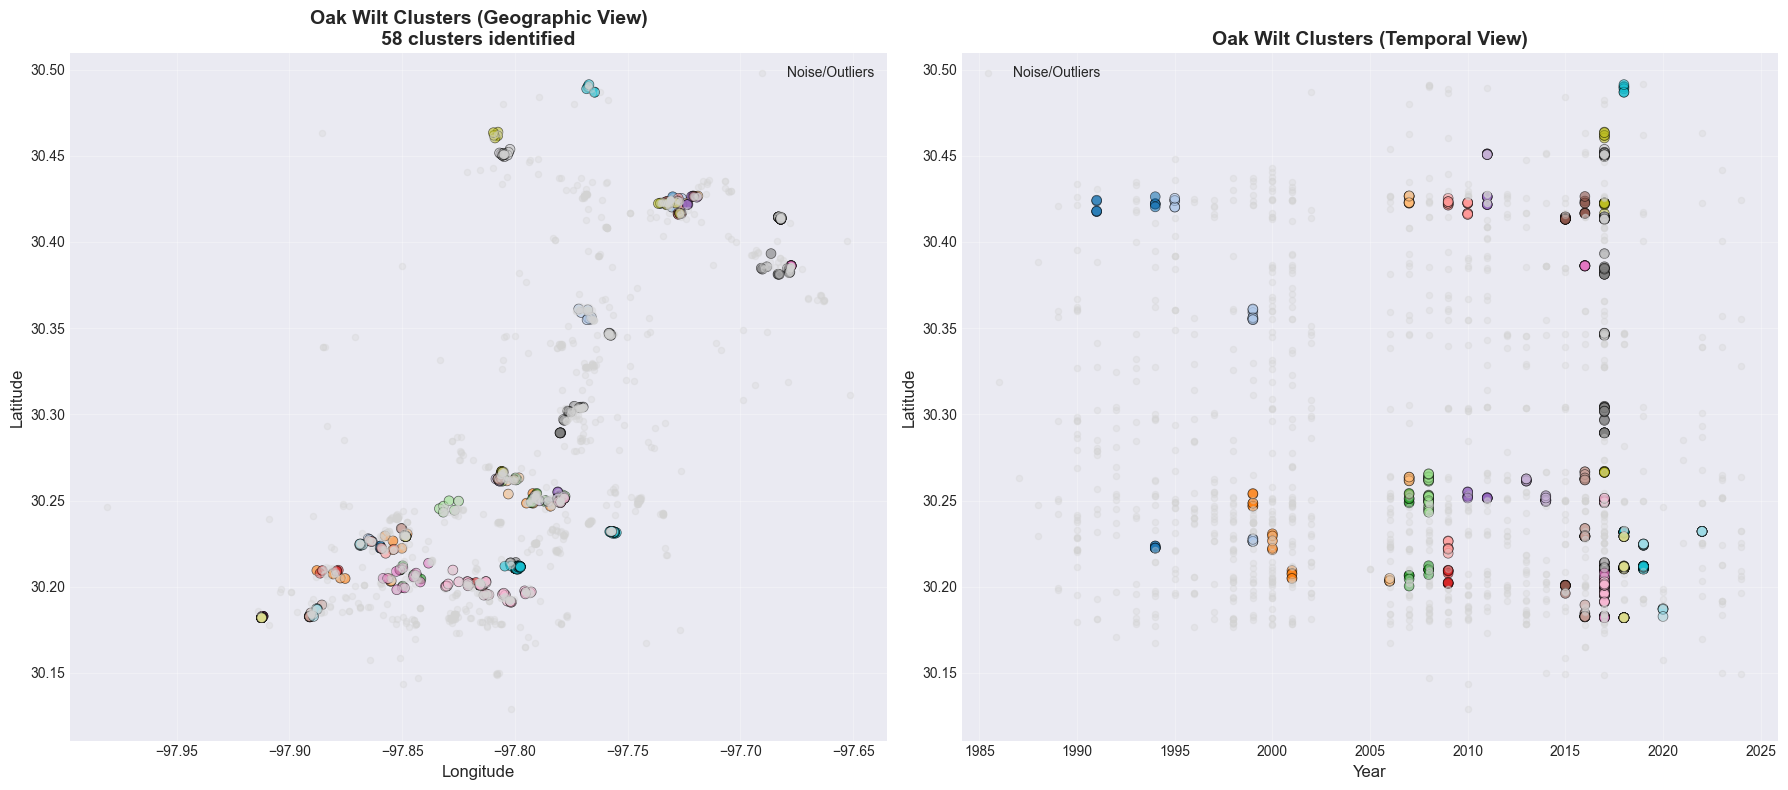

In [6]:
# Create visualization of clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Geographic distribution of clusters
clustered = df_confirmed[df_confirmed['cluster_id'] != -1]
noise = df_confirmed[df_confirmed['cluster_id'] == -1]

# Plot clusters with different colors
scatter1 = ax1.scatter(
    clustered['LONGITUDE'],
    clustered['LATITUDE'],
    c=clustered['cluster_id'],
    cmap='tab20',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Plot noise points in gray
ax1.scatter(
    noise['LONGITUDE'],
    noise['LATITUDE'],
    c='lightgray',
    s=20,
    alpha=0.3,
    label='Noise/Outliers'
)

ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title(f'Oak Wilt Clusters (Geographic View)\n{n_clusters} clusters identified', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Temporal distribution of clusters
scatter2 = ax2.scatter(
    clustered['INSPECTION_YEAR'],
    clustered['LATITUDE'],
    c=clustered['cluster_id'],
    cmap='tab20',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax2.scatter(
    noise['INSPECTION_YEAR'],
    noise['LATITUDE'],
    c='lightgray',
    s=20,
    alpha=0.3,
    label='Noise/Outliers'
)

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)
ax2.set_title('Oak Wilt Clusters (Temporal View)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('../visualizations/clusters/oak_wilt_clusters.png', dpi=300, bbox_inches='tight')
print('✓ Saved visualization to: ../visualizations/clusters/oak_wilt_clusters.png')
plt.show()

✓ Saved distribution plots to: ../visualizations/clusters/cluster_distributions.png


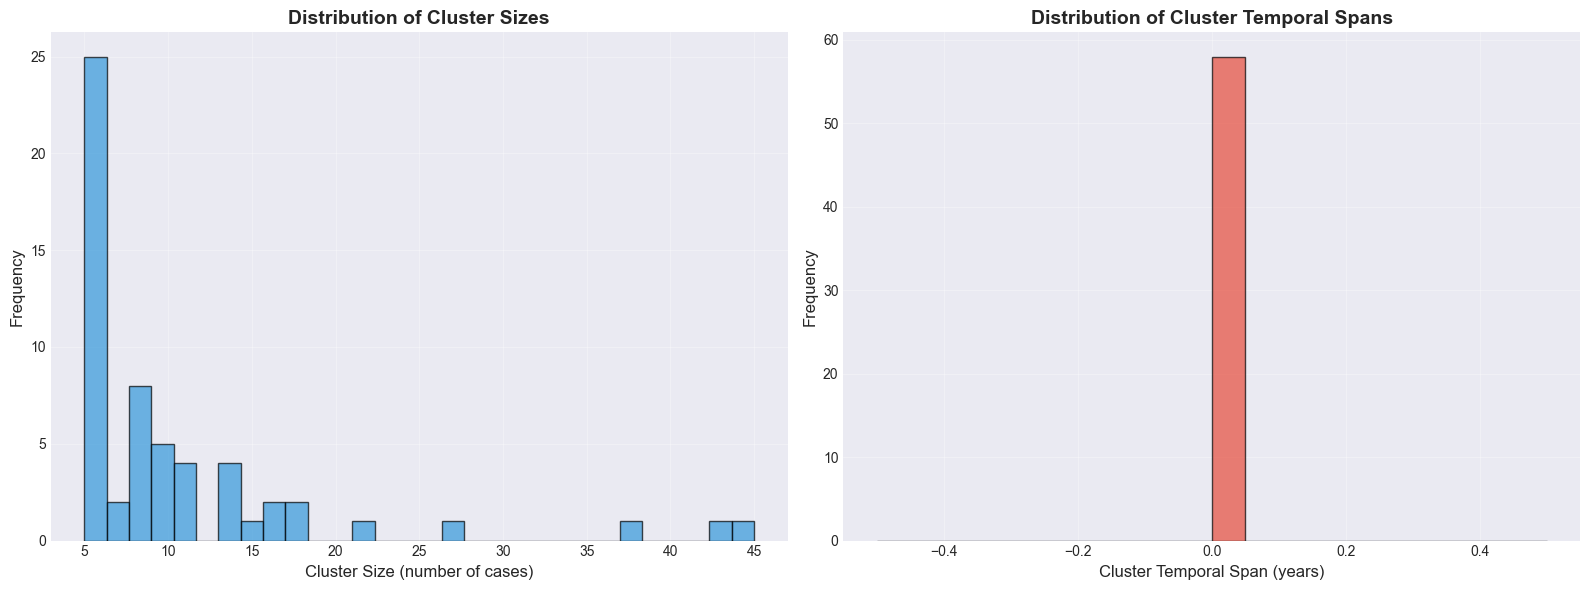

In [7]:
# Additional visualization: Cluster sizes and temporal spans
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of cluster sizes
ax1.hist(cluster_df['size'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Cluster Size (number of cases)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Cluster Sizes', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Histogram of temporal spans
ax2.hist(cluster_df['year_span'], bins=20, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Cluster Temporal Span (years)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Cluster Temporal Spans', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/clusters/cluster_distributions.png', dpi=300, bbox_inches='tight')
print('✓ Saved distribution plots to: ../visualizations/clusters/cluster_distributions.png')
plt.show()

## 7. Create Detailed Cluster JSON Output

Generate comprehensive JSON with all cluster information and individual case details.

In [8]:
# Build comprehensive cluster data structure
clusters_output = {
    'metadata': {
        'generated_date': datetime.now().isoformat(),
        'total_cases': len(df_confirmed),
        'clustered_cases': len(df_confirmed[df_confirmed['cluster_id'] != -1]),
        'noise_cases': n_noise,
        'num_clusters': n_clusters,
        'clustering_parameters': {
            'algorithm': 'DBSCAN',
            'eps': eps,
            'min_samples': min_samples,
            'year_weight': year_weight
        }
    },
    'clusters': []
}

# Add detailed information for each cluster
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:  # Skip noise
        continue
    
    cluster_points = df_confirmed[df_confirmed['cluster_id'] == cluster_id]
    
    # Get all cases in this cluster
    cases = []
    for idx, row in cluster_points.iterrows():
        case = {
            'inspection_id': str(row['Inspection_ID (unique)']) if pd.notna(row['Inspection_ID (unique)']) else None,
            'latitude': float(row['LATITUDE']),
            'longitude': float(row['LONGITUDE']),
            'inspection_date': row['INSPECTION_DATE'].strftime('%Y-%m-%d') if pd.notna(row['INSPECTION_DATE']) else None,
            'inspection_year': int(row['INSPECTION_YEAR']),
            'species': str(row['SPECIES']) if pd.notna(row['SPECIES']) else None,
            'landowner_type': str(row['LANDOWNER_TYPE']) if pd.notna(row['LANDOWNER_TYPE']) else None
        }
        cases.append(case)
    
    # Calculate cluster statistics
    cluster_info = {
        'cluster_id': int(cluster_id),
        'statistics': {
            'total_cases': len(cluster_points),
            'geographic_center': {
                'latitude': float(cluster_points['LATITUDE'].mean()),
                'longitude': float(cluster_points['LONGITUDE'].mean())
            },
            'geographic_bounds': {
                'lat_min': float(cluster_points['LATITUDE'].min()),
                'lat_max': float(cluster_points['LATITUDE'].max()),
                'lon_min': float(cluster_points['LONGITUDE'].min()),
                'lon_max': float(cluster_points['LONGITUDE'].max())
            },
            'temporal_range': {
                'year_start': int(cluster_points['INSPECTION_YEAR'].min()),
                'year_end': int(cluster_points['INSPECTION_YEAR'].max()),
                'year_span': int(cluster_points['INSPECTION_YEAR'].max() - cluster_points['INSPECTION_YEAR'].min())
            },
            'species_distribution': cluster_points['SPECIES'].value_counts().to_dict(),
            'landowner_distribution': cluster_points['LANDOWNER_TYPE'].value_counts().to_dict()
        },
        'cases': cases
    }
    
    clusters_output['clusters'].append(cluster_info)

# Sort clusters by size (largest first)
clusters_output['clusters'].sort(key=lambda x: x['statistics']['total_cases'], reverse=True)

print(f'✓ Prepared cluster data structure')
print(f'  Total clusters: {len(clusters_output["clusters"])}')
print(f'  Total cases included: {sum(c["statistics"]["total_cases"] for c in clusters_output["clusters"])}')

✓ Prepared cluster data structure
  Total clusters: 58
  Total cases included: 613


In [9]:
# Save to JSON file
output_file = '../data/oak_wilt_clusters.json'

with open(output_file, 'w') as f:
    json.dump(clusters_output, f, indent=2)

print(f'✓ Cluster data saved to: {output_file}')
print(f'  File size: {os.path.getsize(output_file) / 1024:.1f} KB')

# Display sample of output structure
print('\nSample cluster (largest cluster):')
sample_cluster = clusters_output['clusters'][0]
print(f"  Cluster ID: {sample_cluster['cluster_id']}")
print(f"  Total cases: {sample_cluster['statistics']['total_cases']}")
print(f"  Geographic center: {sample_cluster['statistics']['geographic_center']}")
print(f"  Temporal range: {sample_cluster['statistics']['temporal_range']}")
print(f"  First 3 cases:")
for i, case in enumerate(sample_cluster['cases'][:3]):
    print(f"    Case {i+1}: {case}")

✓ Cluster data saved to: ../data/oak_wilt_clusters.json
  File size: 204.5 KB

Sample cluster (largest cluster):
  Cluster ID: 49
  Total cases: 45
  Geographic center: {'latitude': 30.210863644444448, 'longitude': -97.79936004444444}
  Temporal range: {'year_start': 2018, 'year_end': 2018, 'year_span': 0}
  First 3 cases:
    Case 1: {'inspection_id': None, 'latitude': 30.210631, 'longitude': -97.799781, 'inspection_date': '2018-04-06', 'inspection_year': 2018, 'species': 'Live Oak', 'landowner_type': 'Public'}
    Case 2: {'inspection_id': None, 'latitude': 30.211998, 'longitude': -97.79871, 'inspection_date': '2018-04-06', 'inspection_year': 2018, 'species': 'Live Oak', 'landowner_type': 'Municipal - Parkland'}
    Case 3: {'inspection_id': None, 'latitude': 30.210626, 'longitude': -97.799773, 'inspection_date': '2018-04-06', 'inspection_year': 2018, 'species': 'Live Oak', 'landowner_type': 'Municipal - Parkland'}


## 8. Cluster Timeline Analysis

Show how clusters evolved over time (spread patterns).

✓ Saved timeline visualization to: ../visualizations/clusters/cluster_timeline.png


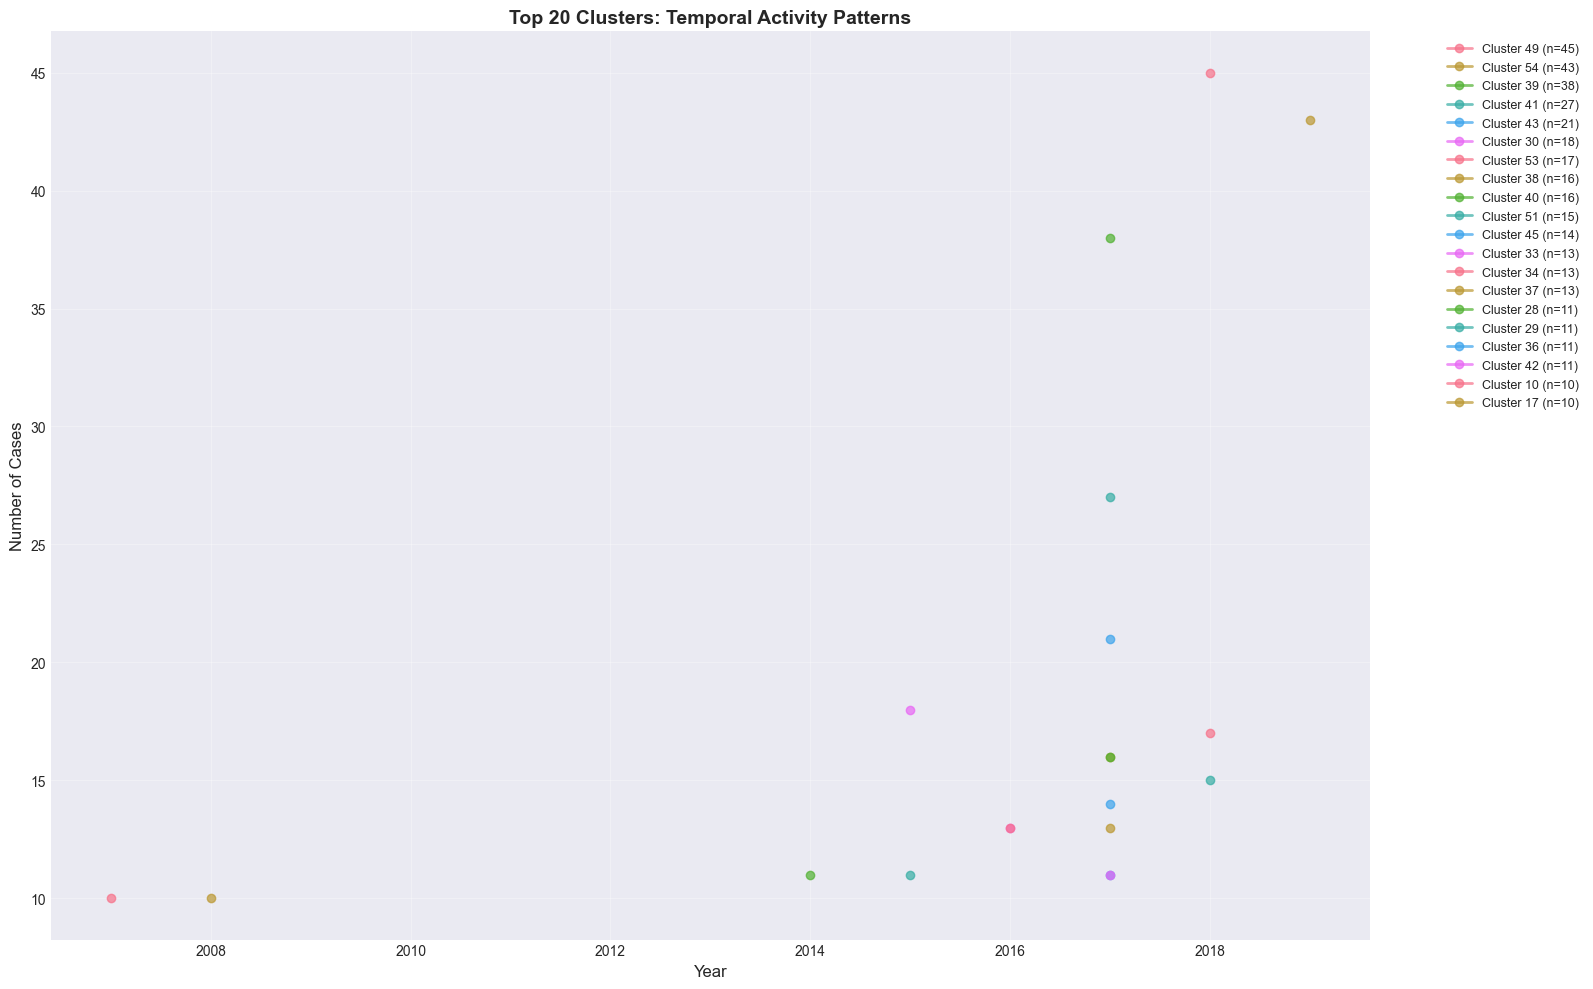

In [10]:
# Create timeline showing cluster activity by year
fig, ax = plt.subplots(figsize=(16, 10))

# Get top 20 largest clusters for visualization
top_clusters = cluster_df.nlargest(20, 'size')['cluster_id'].values

for cluster_id in top_clusters:
    cluster_data = df_confirmed[df_confirmed['cluster_id'] == cluster_id]
    yearly_counts = cluster_data.groupby('INSPECTION_YEAR').size()
    
    ax.plot(yearly_counts.index, yearly_counts.values, marker='o', 
            label=f'Cluster {cluster_id} (n={len(cluster_data)})',
            linewidth=2, markersize=6, alpha=0.7)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Cases', fontsize=12)
ax.set_title('Top 20 Clusters: Temporal Activity Patterns', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/clusters/cluster_timeline.png', dpi=300, bbox_inches='tight')
print('✓ Saved timeline visualization to: ../visualizations/clusters/cluster_timeline.png')
plt.show()

## 9. Summary and Key Insights

In [11]:
print('='*70)
print('CLUSTERING ANALYSIS SUMMARY')
print('='*70)
print(f'\n📊 Overall Statistics:')
print(f'   Total confirmed cases analyzed: {len(df_confirmed):,}')
print(f'   Cases assigned to clusters: {len(df_confirmed) - n_noise:,} ({(len(df_confirmed) - n_noise)/len(df_confirmed)*100:.1f}%)')
print(f'   Noise/outlier cases: {n_noise:,} ({n_noise/len(df_confirmed)*100:.1f}%)')
print(f'   Number of clusters identified: {n_clusters}')

print(f'\n🎯 Cluster Characteristics:')
print(f'   Average cluster size: {cluster_df["size"].mean():.1f} cases')
print(f'   Median cluster size: {cluster_df["size"].median():.0f} cases')
print(f'   Largest cluster: {cluster_df["size"].max()} cases')
print(f'   Smallest cluster: {cluster_df["size"].min()} cases')

print(f'\n⏱️  Temporal Patterns:')
print(f'   Average cluster temporal span: {cluster_df["year_span"].mean():.1f} years')
print(f'   Median cluster temporal span: {cluster_df["year_span"].median():.0f} years')
print(f'   Max cluster temporal span: {cluster_df["year_span"].max()} years')

# Find clusters with longest temporal spans (slow spread)
long_span_clusters = cluster_df.nlargest(5, 'year_span')
print(f'\n📈 Top 5 Clusters by Temporal Span (Persistent Outbreaks):')
for idx, row in long_span_clusters.iterrows():
    print(f'   Cluster {row["cluster_id"]}: {row["year_start"]:.0f}-{row["year_end"]:.0f} ({row["year_span"]} years, {row["size"]} cases)')

# Find largest clusters
large_clusters = cluster_df.nlargest(5, 'size')
print(f'\n🔥 Top 5 Largest Clusters (Hotspots):')
for idx, row in large_clusters.iterrows():
    print(f'   Cluster {row["cluster_id"]}: {row["size"]} cases ({row["year_start"]:.0f}-{row["year_end"]:.0f})')

print(f'\n💾 Output Files Generated:')
print(f'   {output_file}')
print(f'   ../visualizations/clusters/oak_wilt_clusters.png')
print(f'   ../visualizations/clusters/cluster_distributions.png')
print(f'   ../visualizations/clusters/cluster_timeline.png')

print('\n' + '='*70)
print('✓ CLUSTERING ANALYSIS COMPLETE')
print('='*70)

CLUSTERING ANALYSIS SUMMARY

📊 Overall Statistics:
   Total confirmed cases analyzed: 1,672
   Cases assigned to clusters: 613 (36.7%)
   Noise/outlier cases: 1,059 (63.3%)
   Number of clusters identified: 58

🎯 Cluster Characteristics:
   Average cluster size: 10.6 cases
   Median cluster size: 8 cases
   Largest cluster: 45 cases
   Smallest cluster: 5 cases

⏱️  Temporal Patterns:
   Average cluster temporal span: 0.0 years
   Median cluster temporal span: 0 years
   Max cluster temporal span: 0 years

📈 Top 5 Clusters by Temporal Span (Persistent Outbreaks):
   Cluster 0: 1991-1991 (0 years, 5 cases)
   Cluster 1: 1994-1994 (0 years, 5 cases)
   Cluster 2: 1994-1994 (0 years, 6 cases)
   Cluster 3: 1995-1995 (0 years, 5 cases)
   Cluster 4: 1999-1999 (0 years, 8 cases)

🔥 Top 5 Largest Clusters (Hotspots):
   Cluster 49: 45 cases (2018-2018)
   Cluster 54: 43 cases (2019-2019)
   Cluster 39: 38 cases (2017-2017)
   Cluster 41: 27 cases (2017-2017)
   Cluster 43: 21 cases (2017-201